Все технические комментарии прописывала именно в коде, а не в подводке, мне кажется, нельзя писать технические комментарии в коде, не снижайте, пожалуйста

## Начало работы

In [1]:
import geopandas as gpd
import pandas as pd
import json

import os
import json
import requests

In [2]:
base_url = "https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api"
test_id = "11602"

url_get_point_info = f"{base_url}/object/{test_id}"

In [3]:
url_get_point_info

'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/11602'

In [4]:
with open("/content/drive/MyDrive/assets/object.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [5]:
data_relevant = data['data']

latitude = float(data_relevant['objLkLatitude'])
longitude = float(data_relevant['objLkLongitude'])
address = data_relevant['address']
floor_min = data_relevant['floorMin']
floor_max = data_relevant['floorMax']
wall_material = data_relevant['wallMaterialShortDesc']
parking_count = data_relevant['objElemParkingCnt']
class_desc = data_relevant['objLkClassDesc']

df = pd.DataFrame({
    'address': [address],
    'floor_min': [floor_min],
    'floor_max': [floor_max],
    'wall_material': [wall_material],
    'parking_count': [parking_count],
    'class_desc': [class_desc],
    'latitude': latitude,
    'longitude': longitude
})

gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_xy(df['longitude'], df['latitude']), crs=4326)

gdf.explore(tiles='cartodbpositron')

In [6]:
gdf

,address,floor_min,floor_max,wall_material,parking_count,class_desc,latitude,longitude,geometry
0,"г. Мытищи, корпус 49",15,26,Панель,237,Типовой,55.9215,37.7134,POINT (37.7134 55.9215)


Проект находится в городе Мытищи, его северной части. Жилой комплекс «Ярославский», застройщик ООО ЗАГОРОДНАЯ УСАДЬБА, действующий в группе компаний ПИК, 16 октября 2025 года прекративший деятельность на основании определения арбитражного суда о завершении конкурсного производства. Застройщик ориентировался в своей деятельности на массовый сегмент, занимался строительством типовых жилых комплексов, среди которых: «Ярославский», «Цветочные поляны», «Рихард», «Настроение», «Кузьминский лес». Зарегистрировано застрройщик тоже был в Мытищах. Проект введен в эксплуатацию в 1 квартале 2022 года. Типовой класс недвижимости, ДОМ.РФ пишет, что качество воздуха высокое, но я бы поспорила, потому что дом расположен практически на Волковском шоссе, хотя и за ним, конечно, широкая лесополоса, хотя другие рекреационные зоны почти отуствтуют. Рядом достаточно неплохая социальная инфраструктура в виде ТЦ Июнь (в 2013 туда приезжал Snoop Dogg).

# Расчет показателей

Расстояние до центра города. Первым шагом мы оцениваем, насколько жилой комплекс удалён от центра города, поскольку это напрямую влияет на транспортную доступность, стоимость жилья и привлекательность района для разных групп населения. Центр города концентрирует рабочие места, деловую активность и ключевые городские функции, поэтому расстояние до него является важным базовым показателем. Для расчёта используется географическое расстояние между координатами жилого комплекса и условной центральной точкой города, например, главной площади или исторического центра, вычисляемое по координатам широты и долготы.

In [7]:
from geopy.distance import geodesic

city_center = (55.909968, 37.736743)
project_point = (latitude, longitude)

distance_km = geodesic(project_point, city_center).km
print(f"Расстояние до центра города: {distance_km:.1f} км")


Расстояние до центра города: 1.9 км


До центра города почти 2 км, но, честно говоря, из ценного в этом центре есть только здание администрации и транспортная развилка, которая условно делит город на 4 части. Поэтому, я бы лучше смотрела удаленность от метро.

Структура землепользования вокруг объекта. Здесь мы хотим понять, что именно окружает новостройку: жилая застройка, коммерция, дороги, зеленые зоны или смешанная среда. Это важно, потому что контекст района определяет уровень комфорта. Мы считаем доли разных типов землепользования в пределах 800-метрового буфера вокруг комплекса, по сути фактически это то место, в пределах которой целевая массового сегмента ежедневно наиболее часто передвигается.

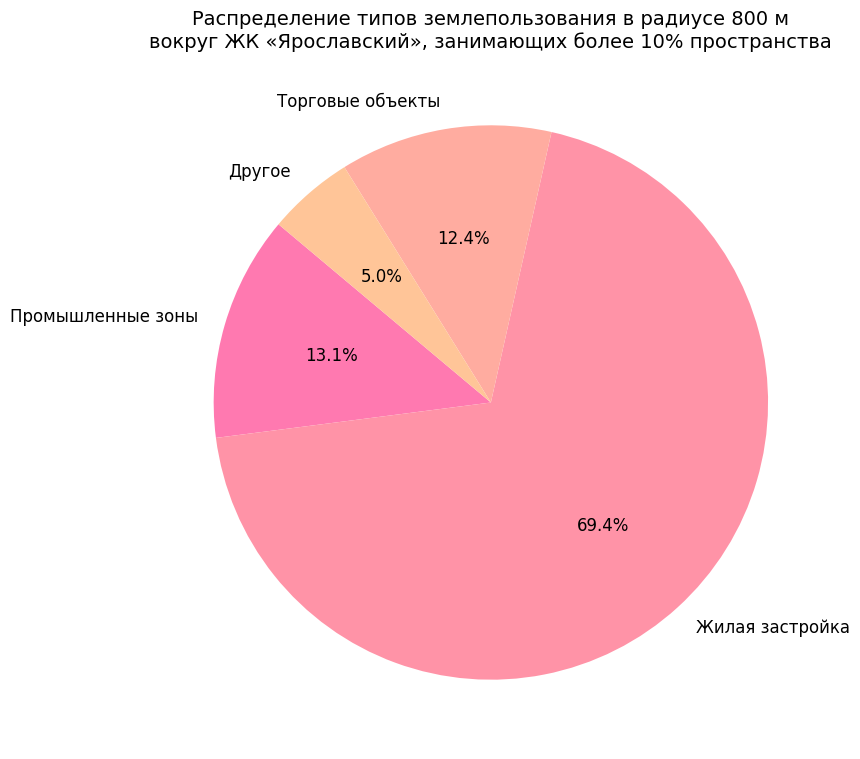

In [10]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt

"""
Создаём точку новостройки
"""
lat = float(data["data"]["objLkLatitude"])
lon = float(data["data"]["objLkLongitude"])
obj_point = gpd.GeoSeries([gpd.points_from_xy([lon], [lat])[0]], crs=4326)

"""
Переводим в метрическую систему координат
"""
utm_crs = 32637
obj_point_utm = obj_point.to_crs(utm_crs)

"""
Создаём буфер 800 м
"""
study_area = obj_point_utm.buffer(800)

"""
Загружаем землепользование вокруг объекта
"""
landuse = ox.features_from_polygon(
    study_area.to_crs(4326).iloc[0],
    tags={"landuse": True}
)

"""
Переводим и обрезаем по зоне анализа
"""
landuse_utm = landuse.to_crs(utm_crs)
landuse_clip = gpd.overlay(
    landuse_utm,
    gpd.GeoDataFrame(geometry=study_area, crs=utm_crs),
    how="intersection"
)

"""
Удаляем категорию свалка, если она присутствует, я честно не поняла, что это
"""
landuse_clip = landuse_clip[landuse_clip["landuse"] != "landfill"]

"""
Вычисляем площади
"""
landuse_clip["area"] = landuse_clip.geometry.area
landuse_stats = landuse_clip.groupby("landuse")["area"].sum()

"""
Считаем доли
"""
total_area = landuse_stats.sum()
landuse_share = (landuse_stats / total_area * 100).round(2)


translate = {
    "residential": "Жилая застройка",
    "commercial": "Коммерческая застройка",
    "retail": "Торговые объекты",
    "industrial": "Промышленные зоны",
    "forest": "Лес",
    "grass": "Травяной покров",
    "meadow": "Луг",
    "farmland": "Сельхоз землю",
    "recreation_ground": "Зона отдыха",
    "allotments": "Садовые участки",
    "construction": "Строительство",
    "garages": "Гаражные территории",
    "brownfield": "Освободившиеся территории",
    "greenfield": "Незастроенные территории",
    "cemetery": "Кладбище",
    "military": "Военные территории",
    "religious": "Религиозные объекты",
    "education": "Образовательные объекты",
    "railway": "Железная дорога",
}

landuse_share_named = landuse_share.rename(index=lambda x: translate.get(x, x))

"""
Объединяем все категории меньше 10% в одну категорию 'Другое'
"""
major = landuse_share_named[landuse_share_named >= 10]
minor = landuse_share_named[landuse_share_named < 10]

if len(minor) > 0:
    major["Другое"] = minor.sum()

landuse_final = major

colors = [
    "#ff79b0",
    "#ff93a7",
    "#ffaca0",
    "#ffc598",
    "#ffdea1",
    "#ffe8a8",
    "#fff0ae",
]

"""
Строим круговую диаграмму
"""
plt.figure(figsize=(9, 9))

plt.pie(
    landuse_final.values,
    labels=landuse_final.index,
    colors=colors[:len(landuse_final)],
    autopct="%1.1f%%",
    startangle=140,
    textprops={"fontsize": 12}
)

plt.title("Распределение типов землепользования в радиусе 800 м\nвокруг ЖК «Ярославский», занимающих более 10% пространства", fontsize=14)
plt.show()

В радиусе 800 метров вокруг ЖК «Ярославский» преобладает жилая застройка, занимает почти 70% территории, что говорит о сформированной жилой среде и ориентации района именно на массовое проживание, а не на какую-то промышленную или деловую функцию. При этом высокая доля промышленных зон и торговых объектов указывает и на возможный смешанный характер окружения, то есть район не прямо спальный, так как сервисные функции в нем присутствуют тоже. Небольшая доля прочих типов землепользования показывает, что свободных или альтернативных пространств немного, а значит территория достаточно плотно и целенаправленно оформлена.

Коэффициент застройки территории. Этот показатель показывает, насколько плотным является окружение новостройки. Если доля застроенной территории большая, значит район плотный и городского типа, если маленькая, то среда более свободная, с большим количеством открытых пространств, скорее даже больше премиум сегмента. Мы считаем отношение площади зданий к общей площади той же буферной зоны.

In [11]:
"""
Загружаем здания OSM внутри той же зоны анализа
"""
buildings = ox.features_from_polygon(
    study_area.to_crs(4326).iloc[0],
    tags={"building": True}
).to_crs(utm_crs)

"""
Оставляем только полигоны, потому что точки и линии OSM нам для застройки не нужны
"""
buildings = buildings[buildings.geom_type.isin(["Polygon", "MultiPolygon"])]

"""
Пересекаем здания с зоной анализа
"""
study_area_gdf = gpd.GeoDataFrame(geometry=study_area, crs=utm_crs)

buildings_clip = gpd.overlay(
    buildings,
    study_area_gdf,
    how="intersection"
)

"""
Считаем площадь зданий
"""
buildings_clip["area"] = buildings_clip.geometry.area
built_area = buildings_clip["area"].sum()

"""
Считаем коэффициент застройки
"""
koef_zastroiki = built_area / total_area

In [12]:
print(f"Коэффициент застройки территории в радиусе 800 м: {koef_zastroiki:.2f}")

Коэффициент застройки территории в радиусе 800 м: 0.23


Есть свободные пространства, внутридворовые зоны и открытые участки. Район не ощущается застроенным под завязку, плотность застройки практически не плотная, территория не выглядит перегруженной, при этом сохраняется баланс между застроенными участками и незастроенными пространствами, такими как дворы, дороги и открытые зоны, что в целом может положительно сказываться на визуальном восприятии района и качестве городской среды.

Удалённость от ключевых объектов. Тут мы считаем фактические расстояния от комплекса до ближайших важных точек, чтобы понять вообще транспортную и пешую доступность до них. Я не знаю, что в Мытищах может быть более ключевым объектом, чем метро, поэтому:

In [13]:
from shapely.geometry import Point
from geopy.distance import geodesic

"""
Указываем координаты метро Медведково, оно точно ближайшее к этому дому
"""
medvedkovo = (55.8870, 37.6610)

obj_coord = (lat, lon)

distance_metro = geodesic(obj_coord, medvedkovo).km


In [14]:
print(f"Расстояние от ЖК Ярославский до метро Медведково: {distance_metro:.1f} км")


Расстояние от ЖК Ярославский до метро Медведково: 5.0 км



Понятное дело, что такое положение типично для периферийных городских округов, огибающих МКАД, но все-таки такая ситуация выводит объект за пределы комфортной пешей доступности к метро и делает жителей в большей степени зависимыми от наземного транспорта. Ключевую роль в транспортной доступности проекта играют в жизни жителей автобусные маршруты, личный автомобиль и организация удобных пересадок, а не шаговая близость к метро.


Доступность образовательных учреждений. Шаговая доступность школ и детских садов это тоже важные факторы комфортной среды. Мы строим зоны доступности по уличной сети, а не по прямой, потому что жители ходят по дорогам, а не по воздуху, и потом смотрим, попадает ли новостройка в эти зоны.

In [16]:
import networkx as nx

lat = float(data["data"]["objLkLatitude"])
lon = float(data["data"]["objLkLongitude"])
gdf = gpd.GeoDataFrame(geometry=[gpd.points_from_xy([lon], [lat])[0]], crs="EPSG:4326")

utm_crs = gdf.estimate_utm_crs()
gdf_proj = gdf.to_crs(utm_crs)

study_area_utm = gpd.GeoDataFrame(
    geometry=gdf_proj.buffer(1500),
    crs=utm_crs
)

study_area_4326 = study_area_utm.to_crs("EPSG:4326")

"""
Достаём сам многоугольник, чтобы OSMnx его подать
"""
polygon_for_osmnx = study_area_4326.geometry.iloc[0]


"""
Загружаем пешеходную сеть вокруг объекта
"""
G = ox.graph_from_polygon(
    polygon_for_osmnx,
    network_type="walk"
)

G = ox.project_graph(G, to_crs=utm_crs)

"""
Загружаем школы и детсады OSM
"""
schools = ox.features_from_point((lat, lon), tags={"amenity": "school"}, dist=1500).to_crs(utm_crs)
kindergartens = ox.features_from_point((lat, lon), tags={"amenity": "kindergarten"}, dist=1500).to_crs(utm_crs)

def make_isochrone(graph, point, radius):
    """Строим изохрону по уличной сети с радиусом, который задали при вызове"""

    """Получаем ближайший узел графа"""
    node = ox.nearest_nodes(graph, point.x, point.y)

    """Строим подграф достижимых узлов"""
    subgraph = nx.ego_graph(
        graph,
        node,
        radius=radius,
        distance="length"
    )

    """Получаем GDF узлов"""
    nodes = ox.graph_to_gdfs(subgraph, nodes=True, edges=False)

    """Так как если узлов мало, то мы не сможем построить изохрону"""
    if len(nodes) < 3:
        return None

    """Строим объединённую оболочку Шапли"""
    return nodes.union_all().convex_hull


obj_utm_point = obj_point_utm.iloc[0]

school_iso = make_isochrone(G, obj_utm_point, 500)
kind_iso = make_isochrone(G, obj_utm_point, 300)

In [17]:
def yes_no(value):
    return "Попадает" if value else "Не попадает"

print("ЖК попадает в зону школ:",
      yes_no(obj_utm_point.within(school_iso)))

print("ЖК попадает в зону детсадов:",
      yes_no(obj_utm_point.within(kind_iso)))

ЖК попадает в зону школ: Попадает
ЖК попадает в зону детсадов: Попадает


Разумеется комплекс попадает в изохронные зоны как школ, так и детских садов, потому что это совеременная новостройка. Это указывает на хорошую обеспеченность территории базовой социальной инфраструктурой в пределах комфортной доступности, что в целом является важным фактором повышения качества жизни и устойчивости жилой среды.


Доступность рекреационных зон. Близость парков, набережных и лесопарков сильно влияет на качество жизни, в особенности, когда дом расположен на шоссе. Мы ищем ближайшие рекреационные зоны вокруг ЖК и считаем расстояние до них.

In [18]:
"""
Загружаем рекреации из OSM
"""
parks = ox.features_from_point((lat, lon), tags={"leisure": "park"}, dist=2000).to_crs(utm_crs)

"""
Cчитаем расстояния от ЖК до всех парков
"""

parks["dist"] = parks.geometry.distance(obj_utm_point)

"""
Выбираем ближайший
"""
nearest_park = parks.loc[parks["dist"].idxmin()]
nearest_park_dist = nearest_park["dist"]

In [19]:
print(f"Расстояние от ЖК Ярославский до ближайшего парка: {nearest_park_dist:.0f} м")

Расстояние от ЖК Ярославский до ближайшего парка: 778 м


По моему мнению, расстояние до ближайшей рекрационной зоны не укладывается в пределы комфортной пешей доступности и делает их просто формально присутствующими на карте, для повышения продаж застройщика, так как все-таки рядом проходит шоссе и место, обеспеченное богатством экологии (и это тоже моя формулировка), должно быть расположено как можно ближе к ЖК.

Доступность общественного транспорта. Считаем расстояние до ближайших остановок (автобус, трамвай) с помощью данных OSM, что помогает оценить реальную транспортную обеспеченность района.

In [20]:
import numpy as np

"""
Загружаем точки общественного транспорта ОТ OSM.
Мы берем только остановки, то есть public_transport=platform
"""
transport = ox.features_from_point(
    (lat, lon),
    tags={"public_transport": "platform"},
    dist=1500
).to_crs(utm_crs)

"""
Считаем расстояние от новостройки до всех остановок
"""
transport["dist"] = transport.geometry.distance(obj_utm_point)

"""
Находим самую близкую остановку
"""
nearest_stop = transport.loc[transport["dist"].idxmin()]
nearest_stop_dist = nearest_stop["dist"]

In [21]:
print(f"Ближайшая остановка общественного транспорта находится в {nearest_stop_dist:.0f} м от ЖК «Ярославский».")

Ближайшая остановка общественного транспорта находится в 134 м от ЖК «Ярославский».


Расстояние до остановки в 134 метра соответствует отличной транспортной доступности на локальном уровне. Такое значение обеспечивает быстрый и удобный доступ к наземному транспорту и частично компенсирует удалённость от станции метро, снижая транспортные издержки для жителей (при условии, что там проходит около 5 автобусов, следующих в центр) и повышая связанность жилого комплекса с остальной городской инфраструктурой.

Существующая плотность населения вокруг новостройки. Плотность населения показывает, насколько свободной является городская среда вокруг новостройки. Мы загружаем набор зданий с населением, например, через OSM или муниципальные данные, и потом пересекаем их с буфером и считаем отношение суммарного населения к площади.

In [22]:
"""
Загружаем все здания вокруг объекта
"""
all_buildings = ox.features_from_point(
    (lat, lon),
    tags={"building": True},
    dist=1500
).to_crs(utm_crs)

"""
Оставляем только полигоны
"""
all_buildings = all_buildings[all_buildings.geom_type.isin(["Polygon", "MultiPolygon"])]

"""
Пересекаем с зоной анализа
"""
all_buildings_clip = gpd.overlay(
    all_buildings,
    gpd.GeoDataFrame(geometry=study_area, crs=utm_crs),
    how="intersection"
)

"""
Методология для выделения жилых домов, а именно убираем промышленные/коммерческие/склады/гаражи, а остальное оставляем всё как потенциальное жилье
"""
non_res_tags = ["industrial", "commercial", "retail", "warehouse", "garage", "roof"]

res_buildings = all_buildings_clip[
    ~all_buildings_clip["building"].isin(non_res_tags)
].copy()

"""
Считаем площадь каждого здания
"""
res_buildings["area"] = res_buildings.geometry.area

"""
Оцениваем население
Используем коэффициент плотности, 1 м2 жилой площади примерно 0.035 человек
"""
res_buildings["population_est"] = res_buildings["area"] * 0.035

"""
Суммарное население и плотность
"""
total_pop_est = res_buildings["population_est"].sum()
pop_density = total_pop_est / total_area

In [23]:
print(f"Оценочное население в радиусе 800 м: {total_pop_est:.0f} человек")
print(f"Плотность населения: {pop_density*1e6:.0f} чел/км2")

Оценочное население в радиусе 800 м: 6639 человек
Плотность населения: 5747 чел/км2


Территория в пределах нормы заселенная, но не перегруженная с точки зрения демографической нагрузки. Такой уровень плотности типичен для сложившихся городских районов с преимущественно среднеэтажной и многоэтажной жилой застройкой, где уже сформирован спрос на повседневную инфраструктуру, при этом плотность не достигает экстремальных значений, что снижает риски перегруженности улично-дорожной сети, социальной инфраструктуры и других общественных мест. В совокупности эти показатели указывают на сбалансированную городскую среду, в которой обеспеченность достаточным числом жителей предполагает экономическую основу для развития сервисов.

Плотность сервисов и коммерческих объектов. Тут мы собираем все объекты с тегом shop=* и amenity=*, считаем их количество в пределах буфера и получаем индекс насыщенности услуг.

In [24]:
"""
Загружаем магазины в радиусе анализа
"""
shops = ox.features_from_point(
    (lat, lon),
    tags={"shop": True},
    dist=1500
).to_crs(utm_crs)

"""
Оставляем только точки, так как магазины чаще всего точечные POI
Если есть полигоны, то берём центроиды, чтобы избежать ошибок
"""
shops = shops.copy()
shops["geometry"] = shops.geometry.centroid

"""
Создаём GeoDataFrame с зоной анализа
"""
study_area_gdf = gpd.GeoDataFrame(geometry=study_area, crs=utm_crs)

"""
Пространственное присоединение, точки магазинов внутри буфера
"""
shops_clip = gpd.sjoin(
    shops,
    study_area_gdf,
    how="inner",
    predicate="within"
)

"""
Считаем количество коммерческих объектов
"""
num_shops = len(shops_clip)
service_density = num_shops / (total_area / 1e6)   # на 1 км2

In [25]:
print(f"В радиусе 800 м расположено {num_shops} коммерческих объектов, что соответствует плотности {service_density:.1f} объектов на км2.")

В радиусе 800 м расположено 145 коммерческих объектов, что соответствует плотности 125.5 объектов на км2.


Несмотря на высокое количество коммерческих объектов в радиусе 800 метров, такую концентрацию, мне кажется, может рассматриваться как негативный фактор для жилой среды. Плотность 125.5 объектов на км2 указывает на перегруженность территории сервисами и торговлей, что часто сопровождается повышенным пешеходным и транспортным трафиком, шумом и увеличенной нагрузкой на улично-дорожную сеть. В таких условяих коммерческие представители будут ориентироваться не только на локальных жителей, но и на внешний поток, что уже снижаестатус тихого спального района. Кроме того, избыток коммерческих функций нередко вытесняет общественные и рекреационные пространства, ухудшая качество дворовой среды и визуальный облик территории, ну и в целом экологической обстановки.


# Интерактивная карта

In [26]:
import folium
from folium import features

"""
Базово настраиваем карту
"""
center_lat = lat
center_lon = lon

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=15,
    tiles='CartoDB positron')


folium.Marker(
    location=[lat, lon],
    tooltip="ЖК «Ярославский»",
    icon=folium.Icon(color="#ffae42", icon="home")
).add_to(m)

study_area_wgs = study_area.to_crs(4326)

folium.GeoJson(
    study_area_wgs.geometry.iloc[0],
    name="Зона анализа, 800 м",
    style_function=lambda x: {"color": "#ab5052", "weight": 2, "fill": False}
).add_to(m)

"""
Выставляем изохроны школ и детских садо
"""

if school_iso is not None:
    school_iso_wgs = gpd.GeoSeries([school_iso], crs=utm_crs).to_crs(4326)
    folium.GeoJson(
        school_iso_wgs.geometry.iloc[0],
        name="Изохрона школ, 500 м",
        style_function=lambda x: {"color": "#a16d55", "weight": 1, "fillOpacity": 0.25}
    ).add_to(m)

if kind_iso is not None:
    kind_iso_wgs = gpd.GeoSeries([kind_iso], crs=utm_crs).to_crs(4326)
    folium.GeoJson(
        kind_iso_wgs.geometry.iloc[0],
        name="Изохрона детсадов, 300 м",
        style_function=lambda x: {"color": "#bc987e", "weight": 1, "fillOpacity": 0.25}
    ).add_to(m)

"""
Школы надо правильно обработать, чтобы отразились, из UTM в centroid и потом в WGS
"""

fg_schools = folium.FeatureGroup(name="Школы")

schools_utm = schools.to_crs(utm_crs).copy()
schools_utm["geometry"] = schools_utm.geometry.centroid
schools_points_wgs = schools_utm.to_crs(4326)

for _, row in schools_points_wgs.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="#f29f6b",
        fill=True,
        fill_opacity=0.9,
        popup=row.get("name", "Школа")
    ).add_to(fg_schools)

fg_schools.add_to(m)

"""
Детские сады надо правильно обработать, чтобы отразились, из UTM в centroid и потом в WGS
"""

fg_kind = folium.FeatureGroup(name="Детские сады")

kind_utm = kindergartens.to_crs(utm_crs).copy()
kind_utm["geometry"] = kind_utm.geometry.centroid
kind_points_wgs = kind_utm.to_crs(4326)

for _, row in kind_points_wgs.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="#b784a7",
        fill=True,
        fill_opacity=0.9,
        popup=row.get("name", "Детский сад")
    ).add_to(fg_kind)

fg_kind.add_to(m)

"""
Школы надо правильно обработать, чтобы отразились, из UTM в centroid и потом в WGS
"""

fg_transport = folium.FeatureGroup(name="Остановки транспорта")

transport_wgs = transport.to_crs(4326)

for _, row in transport_wgs.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,
        color="#ffff81",
        fill=True,
        fill_opacity=0.8,
        popup="Остановка"
    ).add_to(fg_transport)

fg_transport.add_to(m)


"""
Добавляем парки
"""

fg_parks = folium.FeatureGroup(name="Парки")
parks_wgs = parks.to_crs(4326)

for _, row in parks_wgs.iterrows():
    geom = row.geometry
    if geom.geom_type == "Polygon":
        coords = [(y, x) for x, y in geom.exterior.coords]
        folium.Polygon(
            locations=coords,
            color="#ee9086",
            fill=True,
            fill_opacity=0.2,
            popup="Парк"
        ).add_to(fg_parks)

fg_parks.add_to(m)


"""
Добавляем коммерческие объекты
"""

fg_shops = folium.FeatureGroup(name="Коммерческие объекты")
shops_wgs = shops_clip.to_crs(4326)

for _, row in shops_wgs.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,
        color="#a16e3b",
        fill=True,
        fill_opacity=0.9,
        popup=row.get("name", "Коммерческий объект")
    ).add_to(fg_shops)

fg_shops.add_to(m)

"""
Добавляем контроллер слоев
"""
folium.LayerControl().add_to(m)

m.save("mytishchi_project_map.html")

m

/tmp/ipython-input-3558535591.py:19: UserWarning: color argument of Icon should be one of: {'darkgreen', 'purple', 'white', 'darkred', 'gray', 'lightgreen', 'lightgray', 'black', 'blue', 'beige', 'pink', 'lightred', 'darkblue', 'red', 'orange', 'green', 'darkpurple', 'lightblue', 'cadetblue'}.
  icon=folium.Icon(color="#ffae42", icon="home")


В целом проект расположен в достаточно сформированной городской среде, где дом встроен в уже сложившийся жилой район. Это видно по структуре землепользования, так как почти 70% территории вокруг есть жилая застройка, что говорит о стабильном жилом окружении с понятной функцией района. При этом промышленная функция рядом присутствует на 13%, но она не доминирует и находится в пределах городской нормы. Большинство объектов повседневного спроса находятся в шаговой доступности, а также район сбалансирован по плотности населения и не ощущается перегруженным.

Главный минус, а именно удалённость от метро, частично компенсируется близостью остановок общественного транспорта и насыщенностью локальной инфраструктурой.

Преимущества для жителей:

* Школы и детские сады расположены в близлежащей доступности;
* Жители обеспечены высокой плотностью сервисных услуг. В отличие от периферийных новостроек на пустырях, тут уже есть базовая инфраструктура, и это уже повышает качество жизни будущих жителей.;
* Плотность застройки умеренная, как и плотность приуствтсия числа людей на квадратный километр;
* Природные рекреации расположены в относительно приемлемой доступности;

Недостатки для жителей:

* Отсутствует метро в пешей доступности;
* Выскоая концентрация коммерческих объектов дает большой поток людей и шум;
* ЖК стоит практически на крупном магистральном объекте, что минимизирует его экологическую ценность;

Как итог, локацию можно охарактеризовать как типовую и развитую.